In [ ]:
from google.colab import drive
drive.mount('/content/drive/')
os.chdir('/content/drive/My Drive/Colab Notebooks')
!ls
os.chdir('StreetBee')
!ls

# StreetBee. Training classification
### by AIvanov

2) Training set https://gist.github.com/donbobka/9d368b5161351fe4643a3676f0034a0c

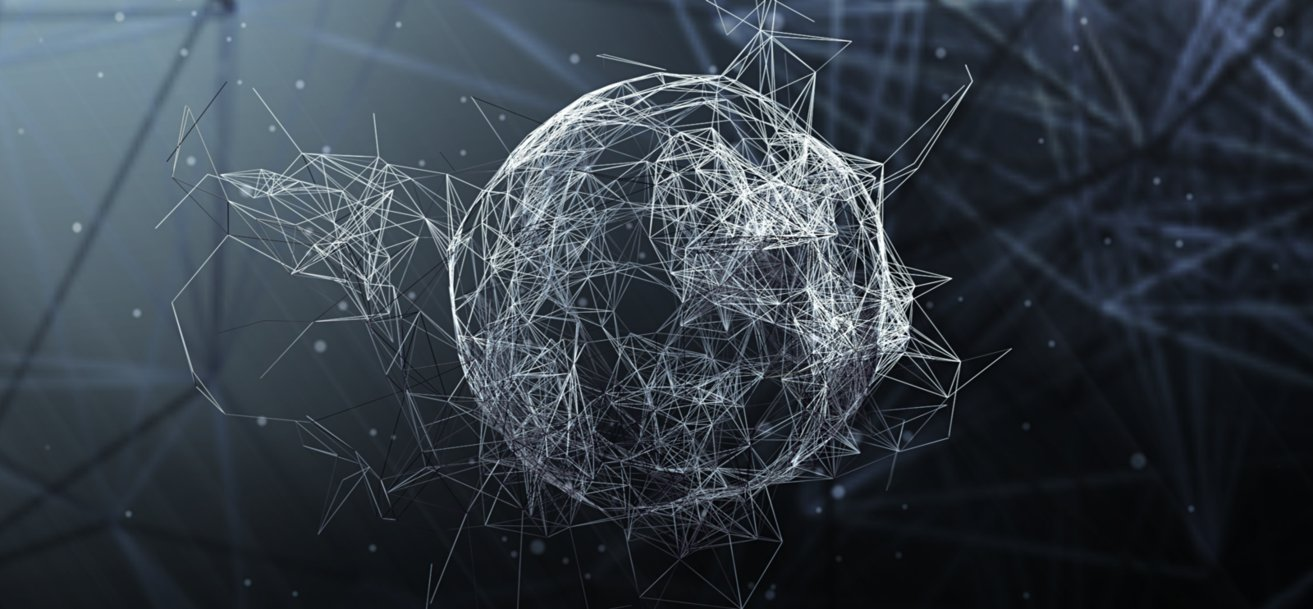

In [1]:
import os
from IPython.display import Image
logo = Image(filename=os.path.join('.', 'logo.jpg'))
display(logo)

In [36]:
import numpy as np
import cv2
import uuid
import torch
import matplotlib.pyplot as plt
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
from shutil import copyfile
import tarfile
import random
import matplotlib.pyplot as plt
import torch.nn as nn

In [3]:
debug = False
torch.cuda.empty_cache()
torch.cuda.device_count()

1

In [4]:
seed = 666
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
cv2.setRNGSeed(seed)

## Define model frome zoo and training ops

### Setup hyper-parameters

In [5]:
data_dir = os.path.join('.', 'data_set')
contents = os.listdir(os.path.join(data_dir, 'val'))
# Number of classes
num_classes = len(contents)
# Batch size for training 64 - based on Google Benchmarks for K80
batch_size = 10 # 8 is for my GPU with 2Gb RAM
# Number of epochs to train for
num_epochs = 8
# learning rate
learning_rate=0.001
#momentum
momentum=0.9

In [6]:
# Detect if we have a GPU available
gpu_available = torch.cuda.is_available()
device = torch.device("cuda:0" if gpu_available else "cpu")
device

device(type='cuda', index=0)

### Training and evaluating

#### Model default location and filename

In [7]:
model = 'model'
model_st_path = os.path.join('.', model, 'state_resNet50.pth')
model_path = os.path.join('.', model, 'resNet50.pth')
model_ft = None

### Load pretrained model

In [8]:
model_ft = torch.load(model_path)

In [9]:
model_ft.load_state_dict(torch.load(model_st_path))

#### Initialize model with desired output configuration

In [17]:
from training import initialize_model
model_ft, input_size = initialize_model(num_classes, model_ft, use_pretrained=True)
model_ft.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=F

### Init loaders

In [14]:
from dataloaders import init_data_loaders

In [15]:
image_datasets, dataloaders_dict = init_data_loaders(input_size, data_dir, batch_size)

Initializing Datasets and Dataloaders...
done


In [16]:
dataloaders_dict

{'train': <torch.utils.data.dataloader.DataLoader at 0x1f0199f89e8>,
 'val': <torch.utils.data.dataloader.DataLoader at 0x1f0199f8a20>,
 'test': <torch.utils.data.dataloader.DataLoader at 0x1f0199f8898>}

## Visualize data set, train model and visualize training

torch.Size([10, 3, 224, 224])


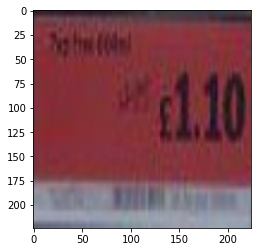

In [18]:
plt.rcParams['figure.figsize'] = [4, 4]

class_names = image_datasets['train'].classes

from confmetrics import norm

for inputs, classes in dataloaders_dict['train']:
    print(inputs.shape)
    sample = norm(inputs[0]).numpy().transpose(1, 2, 0)
    plt.imshow(sample)
    break

### Train model

In [19]:
from training import train_model

In [20]:
torch.cuda.empty_cache()

## Train

In [21]:
model_ft = model_ft.to(device)
params_to_update = model_ft.parameters()

if debug:
    print("Params to learn:")
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            print("\t",name)

optimizer_ft = optim.SGD(params_to_update, lr=learning_rate, momentum=momentum)
criterion = nn.CrossEntropyLoss()

model_ft, hist = train_model(model_ft, dataloaders_dict, criterion, optimizer_ft, device, num_epochs=num_epochs)

Start training for 8 epochs


Phase train | Loss 0.12045 | Acc 0.9000 | f-1 1719.32763671875:  25%|███▌          | 1064/4241 [05:21<15:30,  3.42it/s]

KeyboardInterrupt: 

### Save best checkpoint

In [ ]:
torch.save(model_ft.state_dict(), model_st_path)
torch.save(model_ft, model_path)

### Plot training

In [ ]:
# Plot the training curves of validation accuracy vs. number
#  of training epochs for the transfer learning method
ohist = []
ohist = [h.cpu().numpy() for h in hist]
plt.rcParams['figure.figsize'] = [15, 7]
plt.title("Validation Accuracy vs. Number of Training Epochs")
plt.xlabel("Training Epochs")
plt.ylabel("Validation Accuracy")
plt.plot(range(1,num_epochs+1),ohist,label="Pretrained")
plt.ylim((0,1.))
plt.xticks(np.arange(1, num_epochs+1, 1.0))
plt.legend()
plt.show()

## Visualize test inference

In [41]:
def visualize_model(model, dataloaders, class_names, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    plt.rcParams['figure.figsize'] = [30, 20]
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['test']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                sample = inputs.cpu().data[j].numpy()
                print(sample.shape)
                plt.imshow(sample.transpose(1, 2, 0))

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

(3, 224, 224)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(3, 224, 224)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(3, 224, 224)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(3, 224, 224)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(3, 224, 224)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(3, 224, 224)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


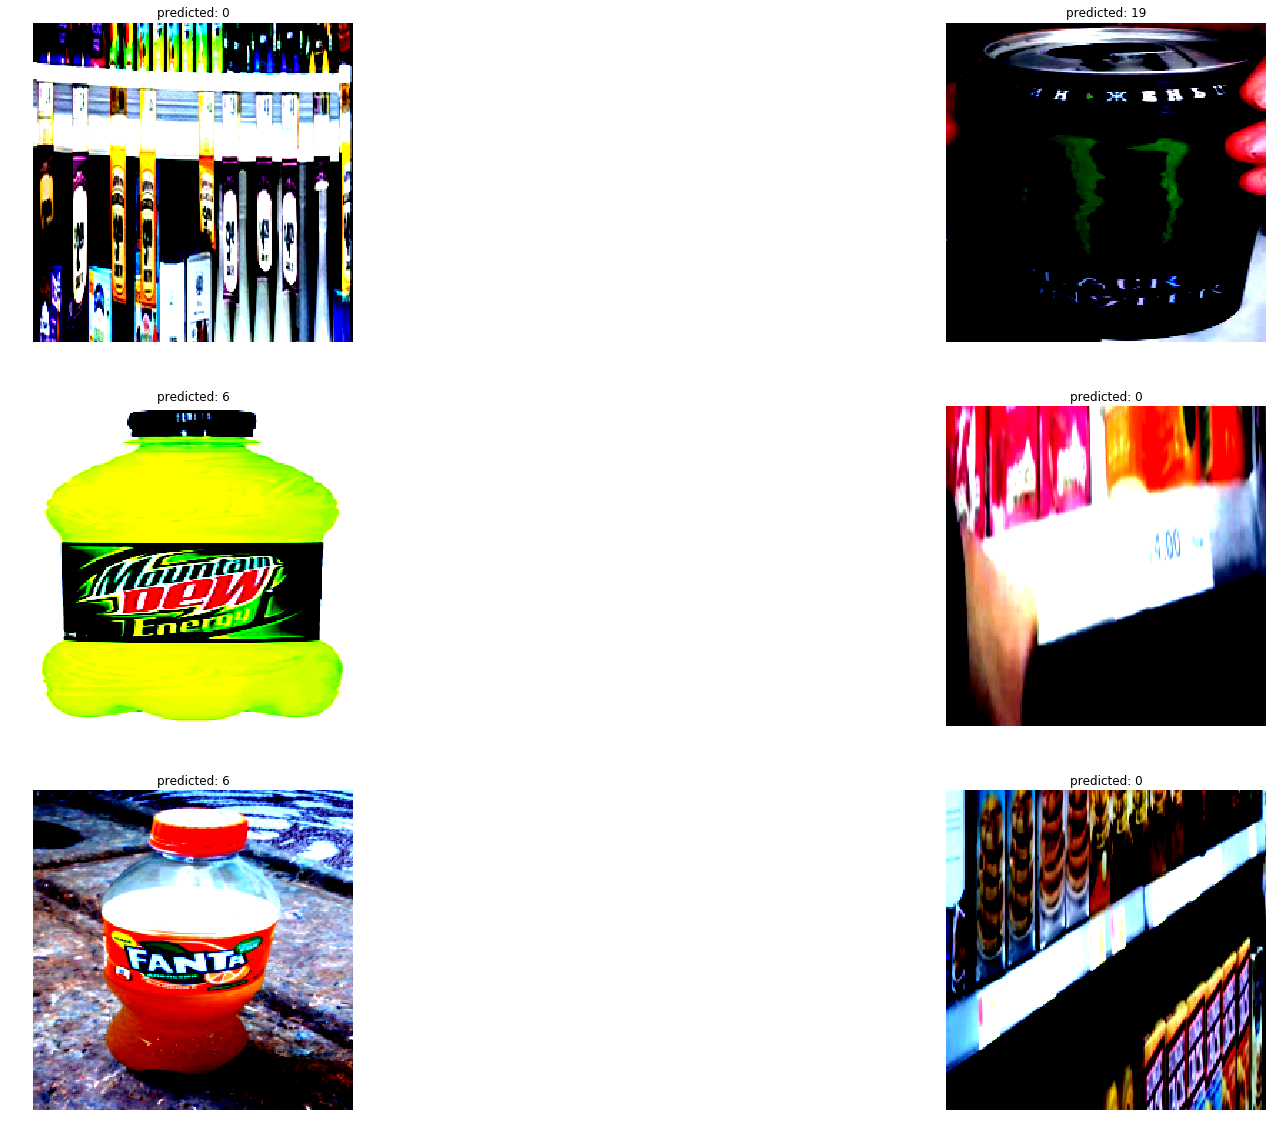

In [42]:
visualize_model(model_ft, dataloaders_dict, class_names)